In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import random
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
random.seed=318
#data_dir = '/content/drive/Othercomputers/My MacBook Pro/PGD isc 2021 Trimester2/AIML421 Machine Learning Tools and Techniques/assignment/Project/traindata'
data_dir ='traindata'
#Applying Transformation
train_transforms = transforms.Compose([transforms.Resize(255), #transforms.Resize(255)
                                       transforms.RandomRotation(30),#transforms.RandomRotation(30)
                                       transforms.RandomResizedCrop(128),
                                       transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
batch_size = 32

train_data = datasets.ImageFolder(data_dir, transform=train_transforms)                                       
#Data Loading
trainloader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, shuffle=True, num_workers=2)
classes = ('cherry', 'strawberry', 'tomato')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


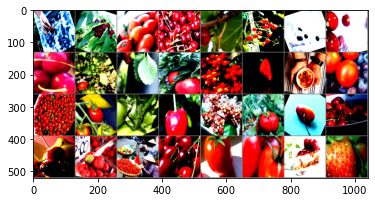

strawberry cherry tomato cherry cherry tomato cherry cherry cherry tomato strawberry tomato strawberry strawberry strawberry tomato cherry tomato tomato cherry strawberry tomato cherry cherry cherry strawberry strawberry cherry tomato tomato strawberry strawberry


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [4]:
# obtain training indices that will be used for validation

# 1. Create a list of indices of the training data  
num_train = len(train_data)
print('num_train = len(train_data) ==> ', num_train)
indices = list(range(num_train))
print('len(indices) ==>', len(indices))

num_train = len(train_data) ==>  4507
len(indices) ==> 4507


In [5]:
# 2. Randomly Shuffle those indices
np.random.shuffle(indices)

In [6]:
# 3. Slice the indices in 80-20 split
# percentage of training set to use as validation
valid_size = 0.2 # ie Train Set divided into two parts  --> 80% Train 20% Validation 
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

print('len(train_idx) ==> ', len(train_idx))
print('len(valid_idx) ==> ', len(valid_idx))

len(train_idx) ==>  3606
len(valid_idx) ==>  901


In [7]:
# Visualize a whole batch of data from the dataloaders 

dataiter = iter(trainloader) # Get the whole batch 
images, labels = dataiter.next() # Extract the images and their labels 
print(len(images), len(labels)) # Should be equal to the batch size, 20
print('Correct Labels: ', labels)
images = images.numpy() # Convert the images to numpy array for matplotlib
print('Shape of our images tensor =', images.shape)
print('Batch Size =', images.shape[0], 'Image Height/Width =', \
                                                        images.shape[2])

print()
print('Squeezing the images tensor =', np.squeeze(images).shape)
print('Un-squeezing the images tensor (axis=3) =', \
                                        np.expand_dims(images, axis=3).shape)

32 32
Correct Labels:  tensor([1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 0, 0, 2, 1, 2, 1, 1, 0,
        0, 2, 0, 0, 2, 2, 0, 0])
Shape of our images tensor = (32, 3, 128, 128)
Batch Size = 32 Image Height/Width = 128

Squeezing the images tensor = (32, 3, 128, 128)
Un-squeezing the images tensor (axis=3) = (32, 3, 128, 1, 128)


In [8]:
import os

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(128 * 128 * 3, 128),
          nn.ReLU(),
          nn.Linear(128, 32),
          nn.ReLU(),
          nn.Linear(32, 3)
        )


    def forward(self, x):
        return self.layers(x)
net1 = MLP()

In [9]:
import torch.nn as nn # nn module contains all the layers 
import torch.nn.functional as F # same as nn, but a little different 

# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5) # 124 X 124
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2) #  62 X 62
        self.conv2 = nn.Conv2d(16, 32, 5) # 58 X 58    
        self.conv3 = nn.Conv2d(32, 64, 5) # 25 X 25
        self.fc1 = nn.Linear(64 * 12 * 12, 180) # 12 x 12 from image dimension
        self.fc2 = nn.Linear(180, 84)
        self.fc3 = nn.Linear(84, 3)
        
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# Instantiate a neural network model 
net2 = Network()
print(net2)

Network(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [10]:
!pip install torchsummary 

/bin/bash: pip: command not found


In [11]:
from torchsummary import summary 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('The model will run on', device)
aiml421 = net2.to(device)
summary(model=aiml421, input_size=(3, 128, 128), batch_size=32) # Summarize

The model will run on cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 124, 124]           1,216
         MaxPool2d-2           [32, 16, 62, 62]               0
            Conv2d-3           [32, 32, 58, 58]          12,832
         MaxPool2d-4           [32, 32, 29, 29]               0
            Conv2d-5           [32, 64, 25, 25]          51,264
         MaxPool2d-6           [32, 64, 12, 12]               0
            Linear-7                  [32, 180]       1,659,060
           Dropout-8                  [32, 180]               0
            Linear-9                   [32, 84]          15,204
           Linear-10                    [32, 3]             255
Total params: 1,739,831
Trainable params: 1,739,831
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 6.00
Forward/backward pass size (MB): 120.05
Pa

In [12]:
# Install Poutyne 
!pip install poutyne 

/bin/bash: pip: command not found


In [13]:
from poutyne.framework import Model # The core datastructure of poutyne 
                                    # https://poutyne.org/model.html

In [14]:
# A pouytne training loop

# A few hyperparamters for the training loop 
learning_rate = 0.001
epochs = 30

def poutyne_train(pytorch_model):
    
    # Select the optimizer and the loss function 
    optimizer = optim.Adam(pytorch_model.parameters(),lr=learning_rate) #
    loss_function = nn.CrossEntropyLoss()
    # Poutyne Model
    model = Model(pytorch_model, optimizer, loss_function, batch_metrics=['accuracy']) #
    # Send the 'Poutyne model' on GPU/CPU whichever is available 
    model.to(device)
    # Train
    history = model.fit_generator(trainloader, validloader, epochs=epochs)
    # Test
    # test_loss, test_acc = model.evaluate_generator(test_loader)
    # print(f'Test:\n\tLoss: {test_loss: .3f}\n\tAccuracy: {test_acc: .3f}')

    return history

In [15]:
train_results = poutyne_train(aiml421)

Epoch:  1/30 Train steps: 141 Val steps: 141 1m56.46s loss: 1.030208 acc: 46.483248 val_loss: 0.968170 val_acc: 50.388285
Epoch:  2/30 Train steps: 141 Val steps: 141 1m58.78s loss: 0.972035 acc: 52.984247 val_loss: 0.939591 val_acc: 53.938318
Epoch:  3/30 Train steps: 141 Val steps: 141 1m56.25s loss: 0.951630 acc: 54.337697 val_loss: 0.991020 val_acc: 50.543599
Epoch:  4/30 Train steps: 141 Val steps: 141 1m57.74s loss: 0.940793 acc: 55.535833 val_loss: 0.929082 val_acc: 54.670513
Epoch:  5/30 Train steps: 141 Val steps: 141 1m58.12s loss: 0.914461 acc: 57.288662 val_loss: 0.971181 val_acc: 52.473929
Epoch:  6/30 Train steps: 141 Val steps: 141 2m0.37s loss: 0.904216 acc: 58.464611 val_loss: 0.882190 val_acc: 59.396494
Epoch:  7/30 Train steps: 141 Val steps: 141 2m1.33s loss: 0.881940 acc: 59.352119 val_loss: 0.855331 val_acc: 61.393388
Epoch:  8/30 Train steps: 141 Val steps: 141 2m1.86s loss: 0.878777 acc: 59.418682 val_loss: 0.839439 val_acc: 61.526514
Epoch:  9/30 Train steps: 1

In [16]:
# Show last step of epochs traning result:
import pandas
train_results = pandas.DataFrame(train_results)
train_results

,epoch,time,loss,acc,val_loss,val_acc
0,1,116.461581,1.030208,46.483248,0.968170,50.388285
1,2,118.778087,0.972035,52.984247,0.939591,53.938318
2,3,116.252466,0.951630,54.337697,0.991020,50.543599
3,4,117.741608,0.940793,55.535833,0.929082,54.670513
4,5,118.115877,0.914461,57.288662,0.971181,52.473929
5,6,120.365200,0.904216,58.464611,0.882190,59.396494
6,7,121.332110,0.881940,59.352119,0.855331,61.393388
7,8,121.861444,0.878777,59.418682,0.839439,61.526514
8,9,124.743248,0.868873,60.505880,0.876365,60.350566
9,10,125.383891,0.862318,61.104948,0.843892,62.147770


#### Plot the training results

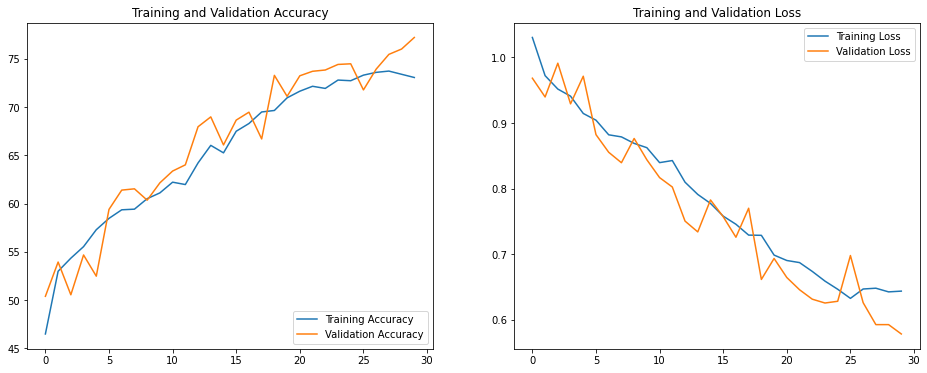

In [17]:
acc = train_results["acc"]
val_acc = train_results['val_acc']

loss = train_results['loss']
val_loss = train_results['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Save the model

In [19]:
PATH = 'model.pth'
torch.save(aiml421.state_dict(),PATH)

#### reference link:
https://colab.research.google.com/github/pranjalchaubey/Deep-Learning-Notes/blob/master/PyTorch%20Image%20Classification%20in%202020/Image_Classification_master.ipynb
https://colab.research.google.com/github/pranjalchaubey/Deep-Learning-Notes/blob/master/PyTorch%20Image%20Classification%20in%202020/Image_Classification_master.ipynb